In [7]:
import shuffles
import numpy as np
import matplotlib.pyplot as plt
from deck import Deck
import seaborn as sns
from sklearn.metrics import mutual_info_score
import shuffles as s
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## What is this code for
Basically this code is a small bit of analysis of some simulated shuffling of cards.
It's to look at patterns created when a deck of cards is shuffled from a known state and ultimately if this information can be exploited.
The shuffles used are in the shuffles.py file and can be added to and most of the shuffles have parameters that can be tuned to try and match the real world.

In [2]:
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Card Position Correlation Matrix")
    plt.xlabel("Card ID")
    plt.ylabel("Card ID")
    plt.show()
    
def plot_transition_matrix(transition_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(transition_matrix, cmap='coolwarm', center=0)
    plt.title("Card Position Transition Matrix")
    plt.xlabel("Card ID")
    plt.ylabel("Card ID")
    plt.show()

def plot_conditional_probabilities(probs, card1, card2):
    plt.figure(figsize=(6, 5))
    plt.imshow(probs, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"P(Card {card2} position | Card {card1} position)")
    plt.xlabel(f"Position of Card {card2}")
    plt.ylabel(f"Position of Card {card1}")
    plt.show()

def plot_mutual_information_matrix(mi_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(mi_matrix, cmap='viridis')
    plt.title("Mutual Information between Card Positions")
    plt.xlabel("Card ID")
    plt.ylabel("Card ID")
    plt.show()
    
def plot_average_displacement(avg_displacement):
    plt.figure(figsize=(6, 3))
    plt.plot(avg_displacement)
    plt.title("Average Displacement of Cards After Shuffling")
    plt.xlabel("Original Card Position")
    plt.ylabel("Average Displacement")
    plt.show()

def plot_position_entropy(entropies):
    plt.figure(figsize=(6, 3))
    plt.plot(entropies)
    plt.title("Entropy of Card Positions After Shuffling")
    plt.xlabel("Card ID")
    plt.ylabel("Entropy (bits)")
    plt.show()
    

def plot_all_graphs(correlation_matrix, transition_matrix, mi_matrix, avg_displacement, entropies, cond_probs, card1, card2):
    fig, axs = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle("Card Shuffling Analysis", fontsize=16)

    # Correlation Matrix
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axs[0, 0])
    axs[0, 0].set_title("Card Position Correlation Matrix")
    axs[0, 0].set_xlabel("Card ID")
    axs[0, 0].set_ylabel("Card ID")

    # Transition Matrix
    sns.heatmap(transition_matrix, cmap='coolwarm', center=0, ax=axs[0, 1])
    axs[0, 1].set_title("Card Position Transition Matrix")
    axs[0, 1].set_xlabel("Card ID")
    axs[0, 1].set_ylabel("Card ID")

    # Average Displacement
    axs[1, 0].plot(avg_displacement)
    axs[1, 0].set_title("Average Displacement of Cards After Shuffling")
    axs[1, 0].set_xlabel("Original Card Position")
    axs[1, 0].set_ylabel("Average Displacement")

    # Conditional Probability
    im = axs[1, 1].imshow(cond_probs, aspect='auto', cmap='viridis')
    axs[1, 1].set_title(f"P(Card {card2} position | Card {card1} position)")
    axs[1, 1].set_xlabel(f"Position of Card {card2}")
    axs[1, 1].set_ylabel(f"Position of Card {card1}")
    plt.colorbar(im, ax=axs[1, 1])

    plt.tight_layout()
    plt.show()

  

In [3]:
# analyses 1 shuffle
def analyse(cards, matrix, orders):
    
    for index, card in enumerate(cards.get()):
        matrix[int(card)][index] += 1
        
    orders.append([list(cards.get()).index(i) for i in range(cards.size)])


# analyses n repetitions of shuffle on a deck of chosen size    
def analyse_n(cards, n, shuffle):
    
    transition_matrix = np.zeros((cards.size, cards.size))
    mi_matrix = np.zeros((cards.size, cards.size))
    probs = np.zeros((cards.size, cards.size))
    e_probs = np.zeros((cards.size, cards.size))
    entropies = np.zeros(cards.size)
    card1 = 0
    card2 = 2
    results = []
    
    for i in range(n):
        cards.shuffle(shuffle)
        analyse(cards, transition_matrix, results)
        cards.reset()
    
    results = np.array(results)
    
    for i in range(cards.size):
        
        mask = results[:, card1] == i
        if np.sum(mask) > 0:
            probs[i] = np.bincount(results[mask, card2], minlength=cards.size) / np.sum(mask)
        
        e_probs = np.bincount(results[:, i], minlength=cards.size) / n
        entropies[i] = -np.sum(e_probs * np.log2(probs + 1e-10))
        
        for j in range(i, cards.size):
            mi = mutual_info_score(results[:, i], results[:, j])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi    
    
    displacements = np.abs(results - np.arange(cards.size))
    avg_displacement = np.mean(displacements, axis=0)
    coefficient = np.corrcoef(np.array(results).T)
    transition_matrix = transition_matrix/n
    
    plot_all_graphs(coefficient, transition_matrix, mi_matrix, avg_displacement, entropies, probs, card1, card2)

In [4]:
# global parameters for now as still figuring out how to go about creating personal shuffles
PORTION = 0.5
STDEV = 0.05
STICKINESS = 0.25

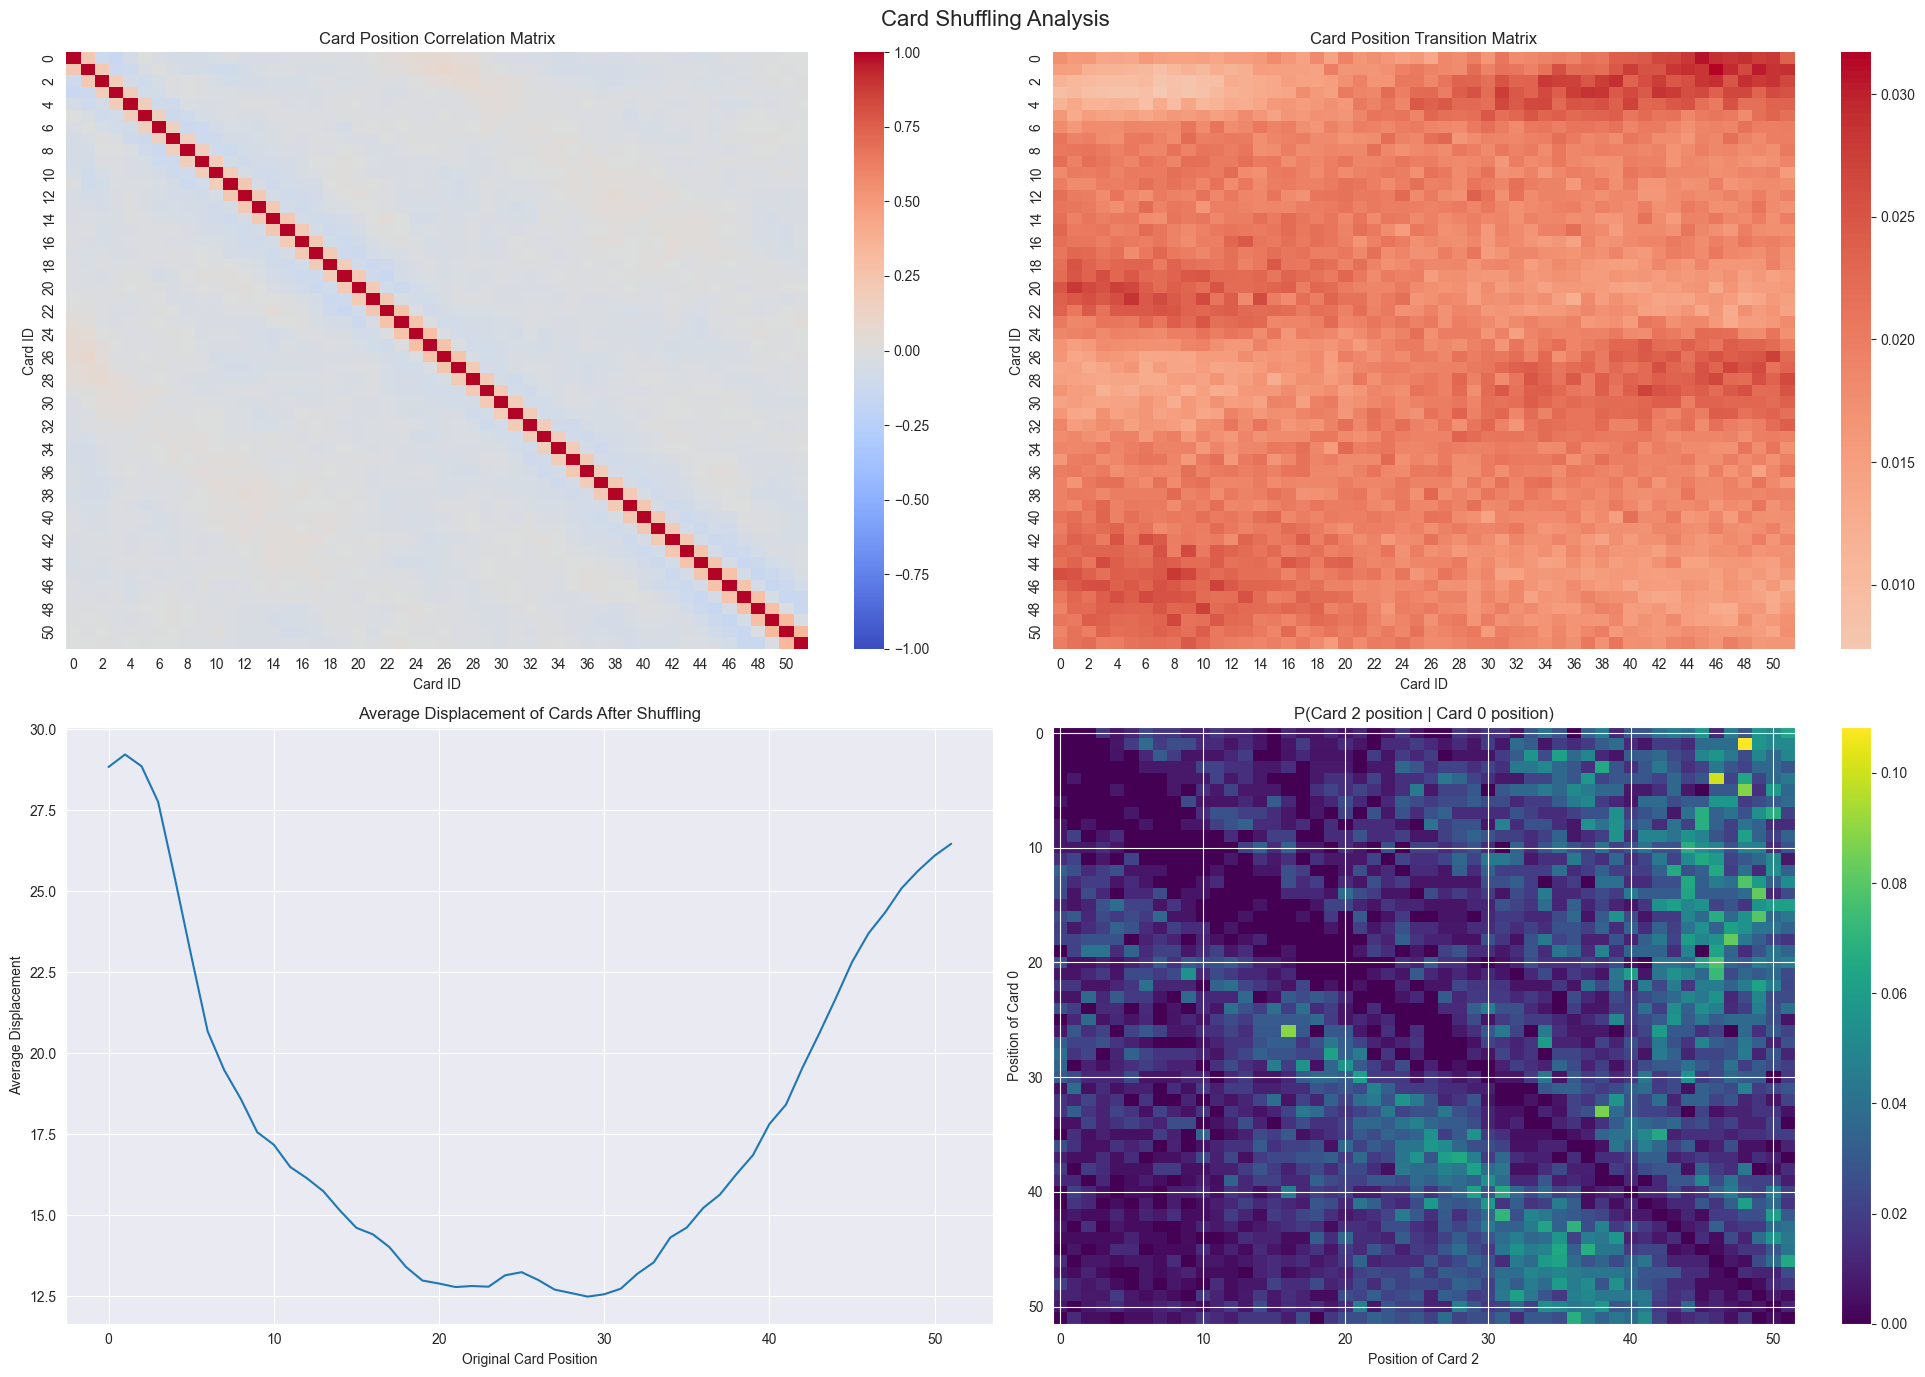

In [5]:
# cut-riffle
def riffle_shuffle(deck):
    a, b = shuffles.cut(deck, PORTION, STDEV)
    deck = shuffles.riffle(a, b, STICKINESS)
    return deck

def box(d):
    d = shuffles.box(d, 6, 0.1)
    return d
        
deck = Deck(52)

analyse_n(deck, 10000, [shuffles.normal])

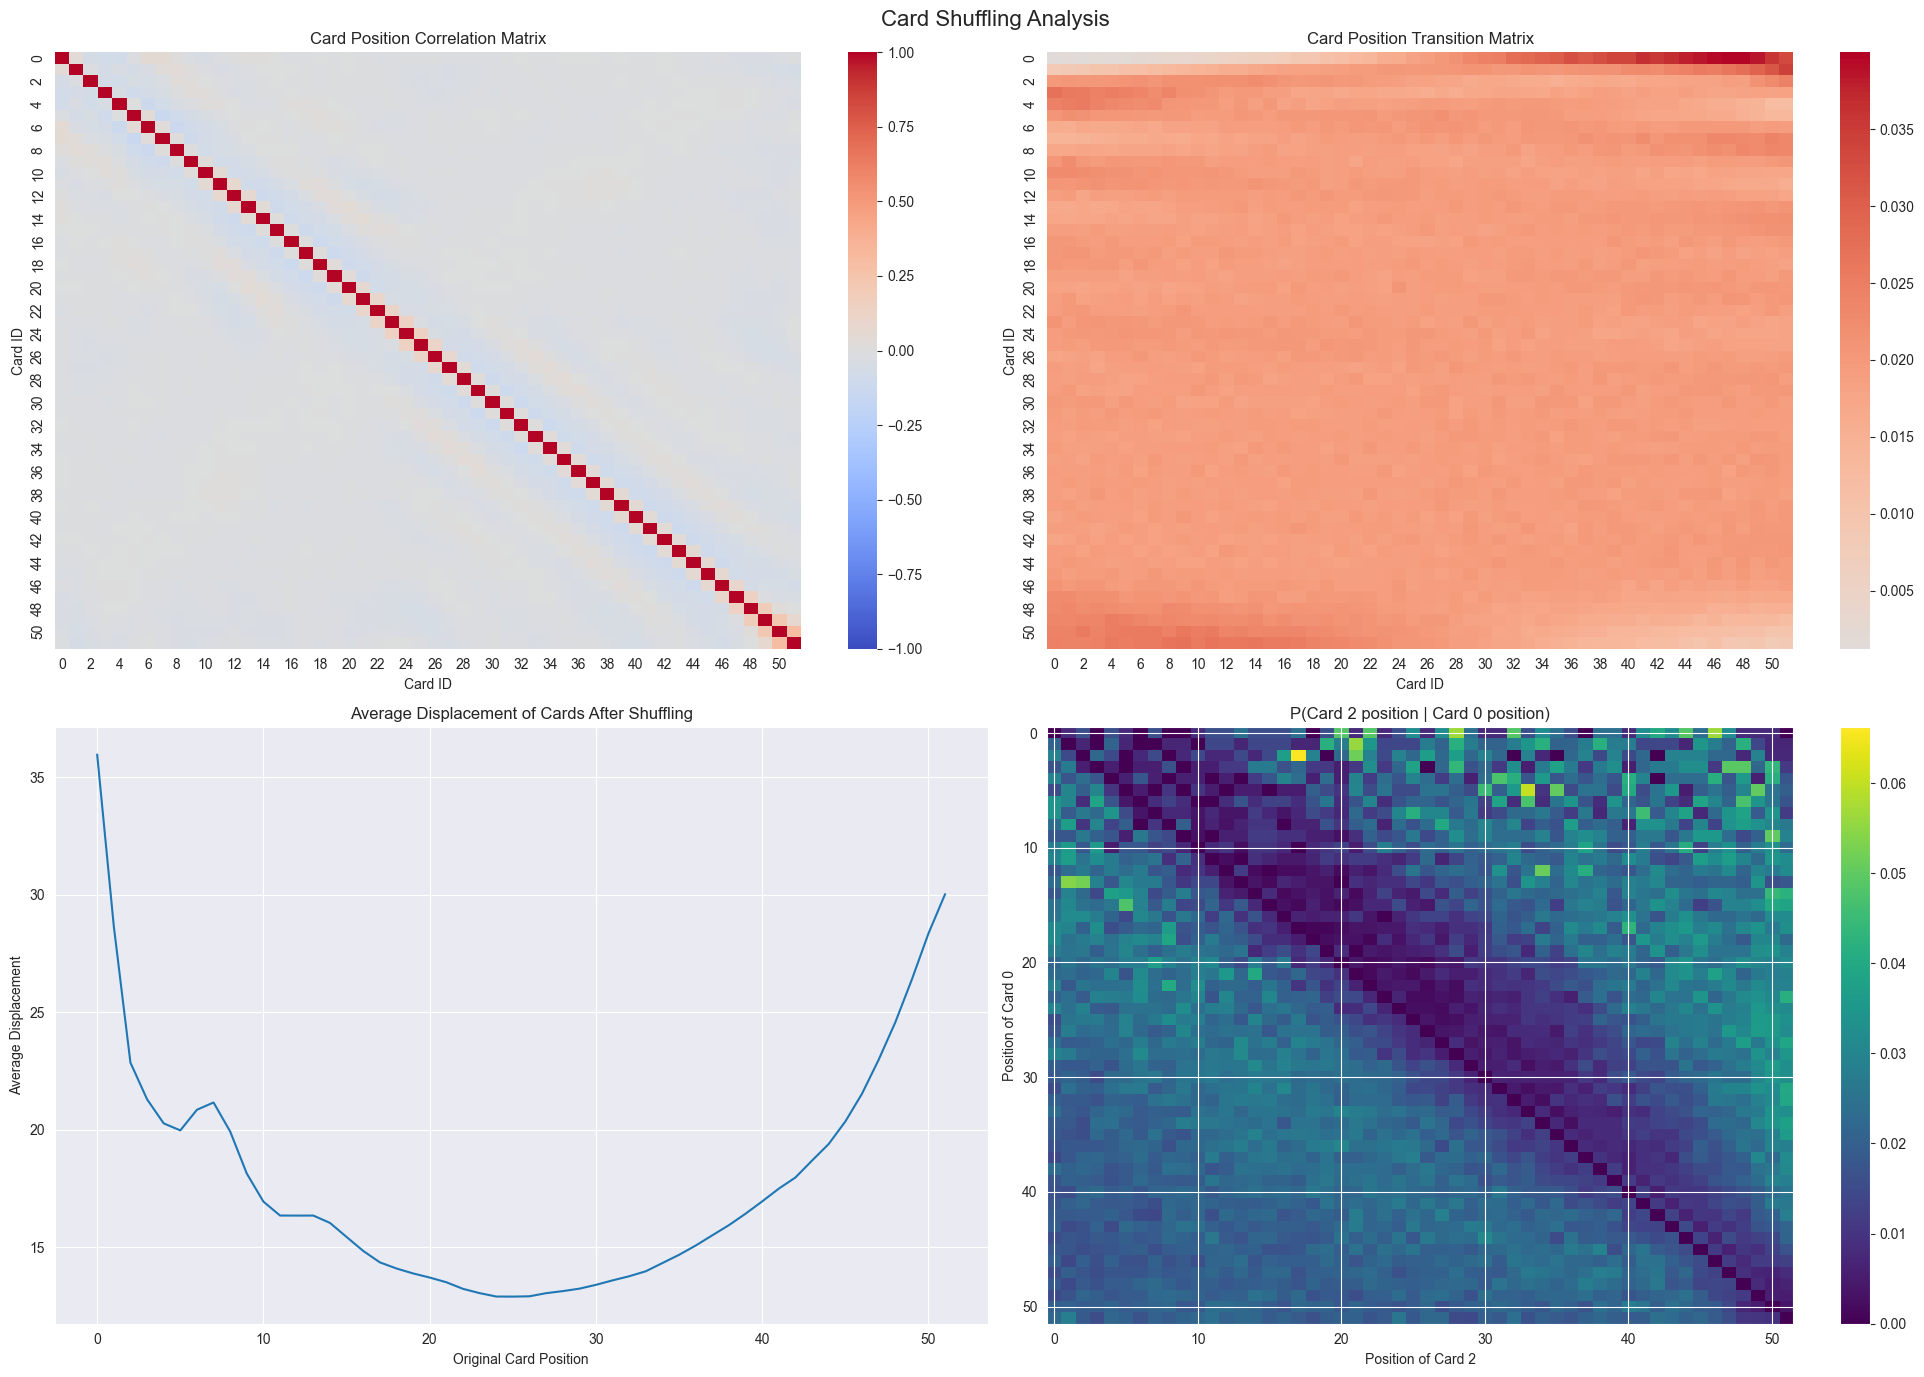

In [9]:
analyse_n(deck, 100000, [riffle_shuffle, riffle_shuffle, riffle_shuffle, box, riffle_shuffle])

In [ ]:
d8 = Deck(52)
a = d8.get()
d = shuffles.custom(a)
analyse_n(d8, 10000, [shuffles.custom])

In [ ]:
from scipy import stats
from tqdm import tqdm
def compute_significant_pairwise_conditional_probabilities(shuffles, num_cards):
    significant_probs = {}
    total_pairs = num_cards * (num_cards - 1)
     
    with tqdm(total=total_pairs, desc="Computing probabilities") as pbar:
        for i in range(num_cards):  # First card (condition)
            for j in range(num_cards):  # Second card (target)
                if i != j:  # We don't compute probabilities for the same card
                    probs = np.zeros((num_cards,num_cards))
                    
                    for k in range(num_cards):  # Position of first card
        
                        mask = shuffles[:, i] == k
                        if np.sum(mask) > 0:
                            probs[k] = np.bincount(shuffles[mask, j], minlength=num_cards) / np.sum(mask)
 
                    
                    significant_probs[(i, j)] = probs
                    
                    pbar.update(1)
        
    return significant_probs

# Example usage
num_cards = 52
num_shuffles = 10000

def gen(n):
    results = []
    cards = Deck(52)
    for i in range(n):
        cards.shuffle([box])
        results.append([list(cards.get()).index(i) for i in range(cards.size)])
        cards.reset()
    
    return np.array(results)

shuffles = gen(10000)

# Compute significant pairwise conditional probabilities
significant_probs = compute_significant_pairwise_conditional_probabilities(shuffles, num_cards)





In [ ]:
c1 = 0
c2 = 1
plt.imshow(significant_probs[(c1, c2)], cmap='viridis', interpolation='nearest')
plt.title("Conditional Probability Distribution: Card 1 given Card 0")
plt.xlabel(f"Position of Card {c1}")
plt.ylabel(f"Position of Card {c2}")
plt.colorbar()
plt.show()
     


In [7]:
import shuffles as s
def gen(n):
    results = []
    cards = Deck(52)
    for i in range(n):
        cards.shuffle([s.normal])
        results.append([list(cards.get()).index(i) for i in range(cards.size)])
        cards.reset()
    
    return np.array(results)

shuffles = gen(100000)


KeyboardInterrupt: 

Epoch 1/7: 100%|██████████| 5000/5000 [00:08<00:00, 588.65it/s]


Epoch 1, Train Loss: 3.8660, Test Loss: 3.7593


Epoch 2/7: 100%|██████████| 5000/5000 [00:08<00:00, 601.17it/s]


Epoch 2, Train Loss: 3.7528, Test Loss: 3.7110


Epoch 3/7: 100%|██████████| 5000/5000 [00:08<00:00, 599.36it/s]


Epoch 3, Train Loss: 3.7063, Test Loss: 3.6981


Epoch 4/7: 100%|██████████| 5000/5000 [00:08<00:00, 592.74it/s]


Epoch 4, Train Loss: 3.6691, Test Loss: 3.6840


Epoch 5/7: 100%|██████████| 5000/5000 [00:08<00:00, 585.76it/s]


Epoch 5, Train Loss: 3.6457, Test Loss: 3.6847


Epoch 6/7: 100%|██████████| 5000/5000 [00:08<00:00, 604.06it/s]


Epoch 6, Train Loss: 3.6246, Test Loss: 3.6866


Epoch 7/7: 100%|██████████| 5000/5000 [00:08<00:00, 605.32it/s]


Epoch 7, Train Loss: 3.6085, Test Loss: 3.6888
5
1
1
1
1
2
3
0
3
2
0
1
3
0
0
0
0
3
3
1
0
2
1
0
3
0
0
2
1
2
1
1
2
1
2
3
0
0
1
0
0
1
0
0
0
0
0
2
0
1
1
1
1
1
0
0
0
0
1
1
1
0
0
1
2
1
1
1
2
2
2
1
2
2
1
0
0
0
1
4
2
1
2
1
0
1
1
3
1
1
0
4
0
0
0
1
2
0
1
1
1
4
2
0
0
0
1
2
1
1
0
1
0
4
3
3
0
2
1
1
0
1
0
0
4
1
0
0
1
2
0
0
3
3
2
0
0
2
1
0
1
1
1
0
2
1
1
0
0
1
1
1
1
3
1
1
0
1
2
0
0
1
1
2
0
0
0
0
0
1
2
2
1
2
1
1
3
2
1
2
1
2
2
3
0
1
1
0
2
0
2
0
2
4
2
0
2
1
2
1
0
0
1
3
1
1
2
0
0
1
1
1
2
3
1
2
0
1
1
2
0
0
0
0
1
0
1
2
1
1
1
0
0
3
1
0
1
2
0
2
0
1
1
0
1
0
1
0
2
3
1
1
1
0
1
0
1
2
0
0
1
0
2
1
1
0
1
1
1
2
0
2
4
0
3
0
3
1
2
4
2
1
1
2
0
1
2
0
1
2
3
0
2
0
0
2
1
4
3
1
1
0
0
1
1
2
1
1
0
0
0
0
4
1
2
1
2
0
0
4
1
0
1
0
0
0
2
3
4
1
1
2
1
2
1
1
2
1
2
0
0
1
1
0
1
1
1
2
1
0
1
2
0
0
1
0
0
0
3
2
0
3
0
2
0
1
2
2
1
0
2
0
1
1
1
2
0
1
0
1
1
1
1
0
1
1
0
2
1
1
1
0
1
1
2
0
0
0
0
0
3
1
1
1
0
0
0
1
0
0
0
0
1
2
2
1
0
1
3
0
1
1
0
0
1
2
2
0
1
1
0
1
2
0
1
0
0
0
0
0
2
1
0
1
1
0
1
2
1
1
2
0
0
1
1
3
1
1
3
1
1
3
2
2
2
1
0
0
0
0
4
1
2
0
1
0
1

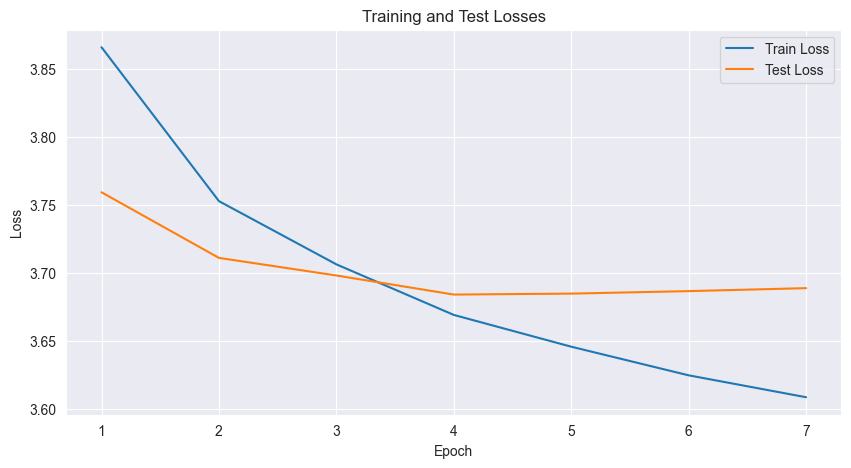

Accuracy for predicting the 21th card: 0.0673


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Define the neural network
class CardPredictionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CardPredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(32, 32, 1)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.drop = nn.Dropout(0.7)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Custom dataset with one-hot encoding
class CardSequenceDataset(Dataset):
    def __init__(self, shuffles, target_position, deck_size):
        self.shuffles = shuffles
        self.target_position = target_position
        self.deck_size = deck_size
        
    def __len__(self):
        return len(self.shuffles)
    
    def __getitem__(self, idx):
        sequence = self.shuffles[idx, :self.target_position]
        target = self.shuffles[idx, self.target_position]
        
        # Create one-hot encoded input
        one_hot_sequence = np.zeros((self.target_position, self.deck_size))
        for i, card in enumerate(sequence):
            one_hot_sequence[i, card] = 1
        
        arr = np.zeros(self.deck_size)
        arr[target] += 1
        target = arr
            
        return torch.FloatTensor(one_hot_sequence.flatten()), torch.FloatTensor(target)

# Calculate loss for a dataset
def calculate_loss(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device="cpu"):
    model.to(device)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        test_loss = calculate_loss(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return train_losses, test_losses

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            _, targets = torch.max(targets, 1)
            total += targets.size(0)
            correct += (predicted == targets.squeeze()).sum().item()
            print((predicted == targets.squeeze()).sum().item())
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Main prediction function
def predict_nth_card(shuffles, n, hidden_size=128, num_epochs=7, batch_size=16):
    num_cards = shuffles.shape[1]
    input_size = num_cards * n  # Size of one-hot encoded input
    
    # Prepare dataset
    dataset = CardSequenceDataset(shuffles, n, num_cards)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = CardPredictionNN(input_size, hidden_size, num_cards)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Set device
    device = torch.device("cuda")
    model.to(device)
    
    # Train the model
    train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
    
    # Evaluate the model
    accuracy = evaluate_model(model, test_loader, device)
    
    # Plot training and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.show()
    
    return model, accuracy, train_losses, test_losses

def generate_shuffles(n_shuffles: int, deck_size: int = 52) -> np.ndarray:
    return np.array([np.random.permutation(deck_size) for _ in range(n_shuffles)])

shuffles = gen(100000)

# Example usage
n = 20
model, accuracy, train_losses, test_losses = predict_nth_card(shuffles, n)
print(f"Accuracy for predicting the {n+1}th card: {accuracy:.4f}")

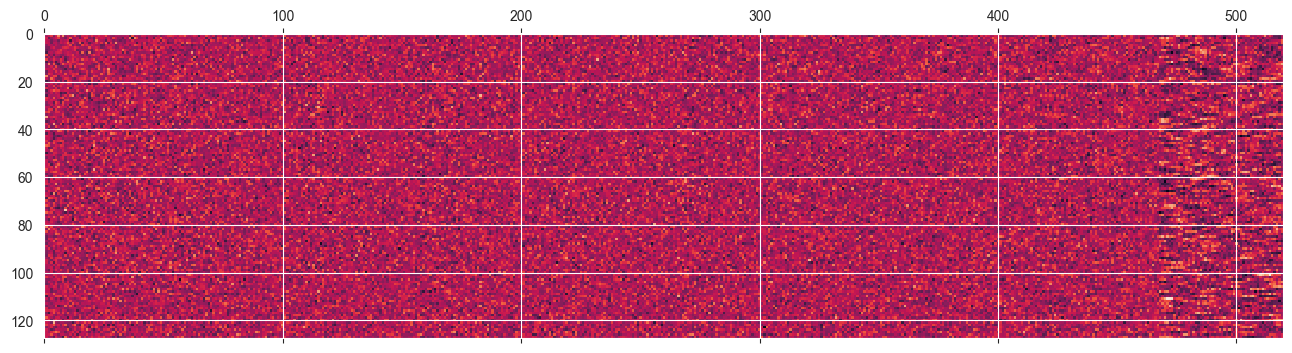

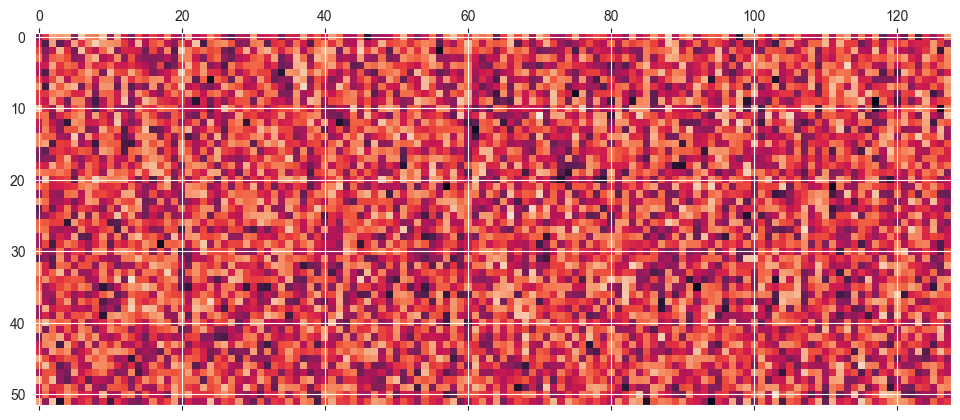

In [24]:
for m in model.modules():
    if isinstance(m, nn.Linear):
        m = m.weight.cpu().detach().numpy()
        plt.matshow(m)
        plt.show()

In [79]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import trange


def random_shuffle(deck):
    return np.random.permutation(deck)

def generate_shuffles(shuffle_function, num_shuffles, deck_size):
    shuffles = []
    for _ in trange(num_shuffles):
        deck = np.arange(deck_size)
        shuffled = shuffle_function(deck)
        shuffles.append(shuffled)
    return np.array(shuffles)

def one_hot_encode_shuffles(shuffles, deck_size):
    num_shuffles = shuffles.shape[0]
    one_hot = np.zeros((num_shuffles, deck_size * deck_size))
    for i, shuffle in enumerate(shuffles):
        for j, card in enumerate(shuffle):
            one_hot[i, j * deck_size + card] = 1
    return one_hot

# Generate data
num_shuffles = 10000
deck_size = 52

normal_shuffles = generate_shuffles(s.normal, num_shuffles, deck_size)
random_shuffles = generate_shuffles(s.custom, num_shuffles, deck_size)

# Combine the data
all_shuffles = np.vstack((normal_shuffles, random_shuffles))

one_hot_shuffles = one_hot_encode_shuffles(all_shuffles, deck_size)
true_labels = np.array([0]*num_shuffles + [1]*num_shuffles)

100%|██████████| 10000/10000 [00:19<00:00, 500.81it/s]


In [83]:
from sklearn.cluster import FeatureAgglomeration
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi


pca = PCA(n_components=2)
first_reduction = pca.fit_transform(one_hot_shuffles)
# Apply t-SNE for dimensionality reduction\

tsne = TSNE(n_components=2, random_state=42, verbose=1)

reduced_data = tsne.fit_transform(first_reduction)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(reduced_data)

# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clusters, style=["Normal"]*num_shuffles + ["Random"]*num_shuffles, palette="deep")
plt.title("t-SNE visualization of Normal vs Random Shuffles")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend(title="Cluster / Shuffle Type")
plt.savefig("shuffle_analysis6.png")
plt.close()

# Calculate accuracy

accuracy = np.mean(clusters == true_labels)
print(f"Clustering Accuracy: {accuracy:.2%}")

# Calculate silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(reduced_data, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.017s...
[t-SNE] Computed neighbors for 20000 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sam

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(one_hot_shuffles, true_labels, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2%}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Random']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Random Forest Results')
plt.ylabel('True Label (0: Normal, 1: Random)')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix_rf.png")
plt.close()

# Feature importance
importances = rf.feature_importances_
feature_importance = np.zeros(deck_size)
for i in range(deck_size):
    feature_importance[i] = np.sum(importances[i::deck_size])

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(deck_size), feature_importance)
plt.title('Feature Importance: Card Positions')
plt.xlabel('Card Position')
plt.ylabel('Importance')
plt.savefig("feature_importance_rf.png")
plt.close()

# Permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
top_k = 20  # Show top 20 features

plt.figure(figsize=(10, 6))
plt.boxplot(perm_importance.importances[sorted_idx][-top_k:].T, 
            vert=False, labels=np.array(range(deck_size * deck_size))[sorted_idx][-top_k:])
plt.title("Permutation Importance (top 20 features)")
plt.xlabel("Decrease in accuracy")
plt.tight_layout()
plt.savefig("permutation_importance_rf.png")
plt.close()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Random Forest Accuracy: 85.00%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.74      0.83       199
      Random       0.79      0.96      0.87       201

    accuracy                           0.85       400
   macro avg       0.87      0.85      0.85       400
weighted avg       0.87      0.85      0.85       400


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do